In [116]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as LinearRegression
from scipy.interpolate import interp1d
# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class~
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

In [117]:
use_resid = False

if use_resid:
    # Load the residuals
    dataset_filename = '../datasets/power_transitions_with_residuals.xlsx'
else:
    dataset_filename = '../datasets/power_transitions.xlsx'

dataset_filename = '..//datasets//pt_sc_imputation_before_1800.xlsx'
polity_df = download_data("https://seshat-db.com/api/core/polities/")
dataset = TSD(file_path=dataset_filename)
dataset.scv = dataset.scv.groupby('dataset').get_group('100y')
dataset.scv_imputed = dataset.scv_imputed.groupby('dataset').get_group('100y')

Downloaded 862 rows
Dataset loaded from ..//datasets\pt_sc_imputation_before_1800.xlsx


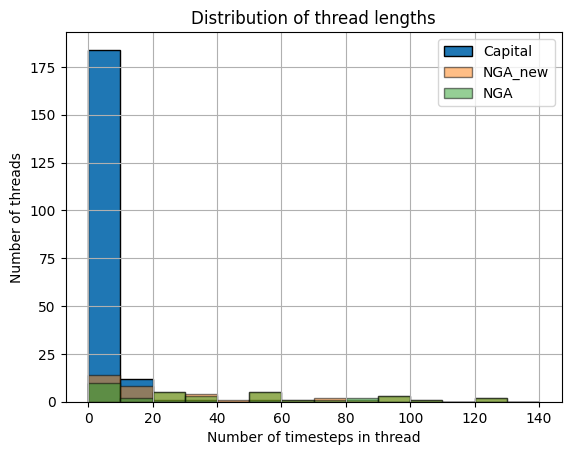

442


In [124]:
capitals = pd.read_excel("..\datasets\polity_capitals.xlsx")
dataset.scv_imputed['capital'] = dataset.scv_imputed.PolityName.apply(
    lambda x: capitals[capitals.polity_id == x].capital.values[0] if x in capitals.polity_id.values else np.nan)

dataset.scv_imputed['NGA_new'] = dataset.scv_imputed['PolityName'].apply(
    lambda x: capitals[capitals.polity_id == x].NGA.values[0] if x in capitals.polity_id.values else np.nan)
dataset.scv_imputed[dataset.scv_imputed['NGA_new'] == 'none'] = np.nan
dataset.scv_imputed.loc[dataset.scv_imputed['NGA_new'].isna() & dataset.scv_imputed['NGA'].notna(),'NGA_new'] = dataset.scv_imputed.loc[dataset.scv_imputed['NGA_new'].isna() & dataset.scv_imputed['NGA'].notna(),'NGA']

dataset.scv_imputed.groupby('capital').size().hist(bins=np.arange(0, 150, 10), edgecolor='black', label='Capital')
dataset.scv_imputed.groupby('NGA_new').size().hist(bins=np.arange(0, 150, 10), edgecolor='black', alpha=0.5, label='NGA_new')
dataset.scv_imputed.groupby('NGA').size().hist(bins=np.arange(0, 150, 10), edgecolor='black', alpha=0.5, label='NGA')
plt.xlabel('Number of timesteps in thread')
plt.legend()
plt.ylabel('Number of threads')
plt.title('Distribution of thread lengths')
plt.show()

# find differences between NGA and NGA_new
diffs = dataset.scv_imputed['NGA_new'] != dataset.scv_imputed['NGA']
nas  = dataset.scv_imputed['NGA_new'].notna() & dataset.scv_imputed['NGA'].isna()
nas_2  = dataset.scv_imputed['NGA_new'].isna() & dataset.scv_imputed['NGA'].isna()

dataset.scv_imputed.loc[diffs & ~nas & ~nas_2, ['PolityName','NGA','NGA_new']]
print(len(dataset.scv_imputed[dataset.scv_imputed.capital.notna()].PolityName.unique()))

import Agri and AgriLag from TableData

In [87]:
import pyreadr

polaris_filename = "..\datasets\Polaris_data.xlsx"
polaris_pol_df = pd.read_excel(polaris_filename, sheet_name='polities')

data = pyreadr.read_r("../datasets/TableData.Rdata")
df = data['ImpSCDat']
df_agri = data['AggrSCWarAgriRelig']

add_cols = ['Metal','Project','Weapon','Animal','Armor','Defense','Cavalry','Iron','Agri','AgriLag']
for col in add_cols:
    df[col] = df_agri[col]

col_replacements = {'Time': 'Year', 'Hier':'Hierarchy', 'Gov':'Government', 'Infra':'Infrastructure',
                    'Info': 'Information'}
df = df.rename(columns=col_replacements)
df['PolityName'] = df['PolID'].apply(lambda x: polaris_pol_df.loc[polaris_pol_df['polity_old_ID'] == x, 'PolID'].values[0] if x in polaris_pol_df['polity_old_ID'].values else np.nan)
# df['PolityID'] = df['PolID'].apply(lambda x: polity_df.loc[polity_df['polity_old_ID'] == x, 'id'].values[0] if x in polity_df['name'].values else np.nan)
df.drop_duplicates(subset=['PolityName', 'Year'], inplace=True)

dataset_old = TSD(file_path=dataset_filename)
dataset_old.scv_imputed = df
# compute scale variable
scale_pca_cols = ['Pop','Terr','Cap']
scale_pca = dataset_old.compute_PCA(cols = scale_pca_cols, col_name = 'Scale', n_cols = 1, n_PCA= len(scale_pca_cols))
lm_df = dataset_old.scv_imputed[['Pop', 'Scale_1']].dropna()
X = lm_df[['Pop']]
y = lm_df['Scale_1']

# Normalize the Scale column to Pop
# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Extract the coefficients
intercept = model.intercept_
slope = model.coef_[0]
dataset_old.scv_imputed['Scale_1'] = (dataset_old.scv_imputed['Scale_1'] - intercept) / slope

# Add the Scale_1 column to the dataset
df['Scale_1'] = dataset_old.scv_imputed['Scale_1']
# compute comp variable]
comp_mapping = {'Comp':{'Government': 11, 'Infrastructure': 12, 'Information':13, 'Money': 6}}
dataset_old.scv_imputed['Comp'] = dataset_old.scv_imputed.apply(lambda row: weighted_mean(row, comp_mapping,category = 'Comp',imputation = "remove", min_vals=0.5), axis=1)

df["Comp"] = dataset_old.scv_imputed["Comp"]

Dataset loaded from ..//datasets\pt_sc_imputation_before_1800.xlsx
Explained variance by each PC:
PC1: 91.36%
PC2: 7.04%
PC3: 1.60%


In [88]:
if 'Agri' not in dataset.scv.columns:
    add_cols = ['Agri','AgriLag']
    for col in add_cols:
        dataset.scv[col] = np.nan
    # add cols to dataset by merging on PolityID and year from df_agri
    for n, row in df.iterrows():
        for col in add_cols:
            dataset.scv.loc[(dataset.scv['PolityName'] == row['PolityName']) & (dataset.scv['Year'] == row['Year']), col] = row[col]
            if len(dataset.scv.loc[(dataset.scv['PolityName'] == row['PolityName']) & (dataset.scv['Year'] == row['Year'])]) > 1:
                print(row['PolityName'], row['Year'])
                
    # fill in missing values for Agri and AgriLag when a polity has only some years missing
    for pol in dataset.scv.PolityName.unique(): 
        for col in add_cols:
            if dataset.scv.loc[dataset.scv['PolityName'] == pol, col].isna().any() and dataset.scv.loc[dataset.scv['PolityName'] == pol, col].notna().any():
                if col == 'Agri':
                    dataset.scv.loc[dataset.scv['PolityName'] == pol, col] = dataset.scv.loc[dataset.scv['PolityName'] == pol, col].fillna(method='ffill')
                elif col == 'AgriLag':
                    # calculate change in year and add to agrilag value
                    agrilag = dataset.scv.loc[(dataset.scv['PolityName'] == pol)&(dataset.scv["AgriLag"].notna()), col].iloc[0]
                    year = dataset.scv.loc[(dataset.scv['PolityName'] == pol)&(dataset.scv["AgriLag"].notna()), 'Year'].iloc[0]
                    year_diff = year - dataset.scv.loc[(dataset.scv['PolityName'] == pol), 'Year']
                    dataset.scv.loc[dataset.scv['PolityName'] == pol, col] = dataset.scv.loc[dataset.scv['PolityName'] == pol, col].fillna(agrilag - year_diff)

transfer_cols = ['Agri','AgriLag']
for col in transfer_cols:
    dataset.scv_imputed[col] = dataset.scv[col]

plot new (imputed) data against Tabledata

TypeError: eval() arg 1 must be a string, bytes or code object

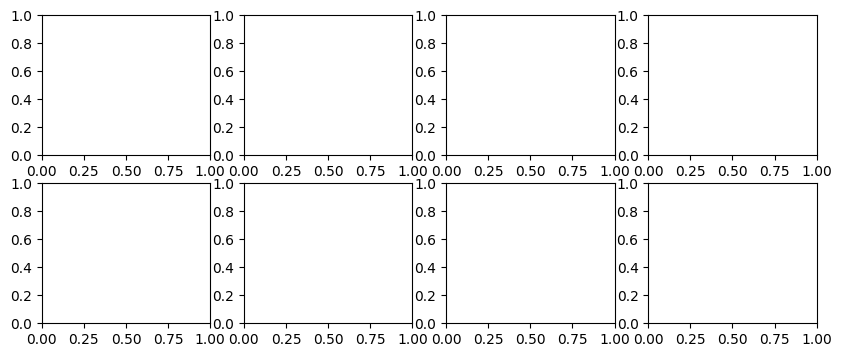

In [89]:
fig, ax = plt.subplots(2, 4, figsize=(10, 4))
ax = ax.flatten()
scale_cols = ['Pop','Terr','Cap']
non_scale_cols = ['Government','Infrastructure','Information','Money']
for c,col in enumerate(scale_cols+['Hierarchy']+non_scale_cols):
    dataset.scv_imputed["color"] = dataset.scv_imputed.fit.apply(lambda x: eval(x)[list(dataset.scv.columns).index(col)])
    df_merge = df[['PolityName','Year',col]].merge(dataset.scv_imputed[['PolityName','Year',col, "color"]], on=['PolityName','Year'], suffixes=('_old','_new'))
    df_merge['diff'] = df_merge[col+'_old'] - df_merge[col+'_new']
    df_merge['diff'] = df_merge['diff'].abs()
    df_merge = df_merge.sort_values('diff', ascending=False)

    ax[c].scatter(df_merge[col+'_old'], df_merge[col+'_new'], c = df_merge.color, cmap="tab10", alpha=0.5, s = 4)
    # df_merge = df[['PolityName','Year',col]].merge(dataset.scv[['PolityName','Year',col]], on=['PolityName','Year'], suffixes=('_old','_new'))
    # ax[c].plot(df_merge[col+'_old'], df_merge[col+'_new'], '.', color ="goldenrod", alpha=0.5, markersize = 4)

    ax[c].set_ylabel(col+'_new')
    ax[c].set_xlabel(col+'_old')
    ax[c].set_title(col)
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax = ax.flatten()

for c,col in enumerate(["Scale_1","Comp"]):
    dataset.scv_imputed["color"] = dataset.scv_imputed.fit.apply(lambda x: eval(x)[list(dataset.scv.columns).index("Government")])
    df_merge = df[['PolityName','Year',col]].merge(dataset.scv_imputed[['PolityName','Year',col, "color"]], on=['PolityName','Year'], suffixes=('_old','_new'))
    df_merge['diff'] = df_merge[col+'_old'] - df_merge[col+'_new']
    df_merge['diff'] = df_merge['diff'].abs()
    df_merge = df_merge.sort_values('diff', ascending=False)

    ax[c].scatter(df_merge[col+'_old'], df_merge[col+'_new'], c = df_merge.color, cmap="tab10", alpha=0.5, s = 4)
    # df_merge = df[['PolityName','Year',col]].merge(dataset.scv[['PolityName','Year',col]], on=['PolityName','Year'], suffixes=('_old','_new'))
    # ax[c].plot(df_merge[col+'_old'], df_merge[col+'_new'], '.', color ="goldenrod", alpha=0.5, markersize = 4)

    ax[c].set_ylabel(col+'_new')
    ax[c].set_xlabel(col+'_old')
    ax[c].set_title(col)
plt.tight_layout()
plt.show()

In [ ]:
df_merge = df[['PolityName','Year',"Government","Comp"]].merge(dataset.scv_imputed[['PolityName','Year',"Government","Comp", "color"]], on=['PolityName','Year'], suffixes=('_old','_new'))
diff_polities = df_merge.loc[(df_merge["Government_old"] == 0) & (df_merge["Government_new"] > 0.3),"PolityName"].unique()

sc_cols = ["Year"] + scale_cols + ['Hierarchy'] + non_scale_cols + ['Scale_1','Comp']
for i in range(len(diff_polities)):
    print(diff_polities[i])
    display(df[df.PolityName == diff_polities[i]][sc_cols])
    display(dataset.scv_imputed[dataset.scv_imputed.PolityName == diff_polities[i]][sc_cols])
    display(dataset.scv[dataset.scv_imputed.PolityName == diff_polities[i]][sc_cols[:-2]])
    dataset.scv_imputed.loc[dataset.scv_imputed.PolityName == diff_polities[i], "Government"] = 0

tr_tabal_k


Year       Pop     Terr       Cap  Hierarchy  Government  Infrastructure  \
599  -900  5.055952  3.69897  4.041991   3.333333         0.0             0.9   

     Information     Money   Scale_1  Comp  
599     0.223077  0.166667  4.869024  0.35

Year       Pop      Terr       Cap  Hierarchy  Government  \
4989 -900.0  5.067153  3.663653  4.155647   3.223776    0.423432   
4990 -800.0  5.067153  3.663653  4.155647   3.223776    0.423432   

      Infrastructure  Information     Money   Scale_1      Comp  
4989             1.0          0.2  0.166667  4.947931  0.482328  
4990             1.0          0.2  0.166667  4.947931  0.482328

Year  Pop      Terr  Cap  Hierarchy  Government  Infrastructure  \
4989 -900.0  NaN  3.663653  NaN   3.223776         NaN             1.0   
4990 -800.0  NaN  3.663653  NaN   3.223776         NaN             1.0   

      Information     Money  
4989          0.2  0.166667  
4990          0.2  0.166667

tr_phrygian_k


Year      Pop  Terr       Cap  Hierarchy  Government  Infrastructure  \
600  -800  6.09691   5.0  4.243038   3.833333         0.0            0.96   
601  -700  6.09691   5.0  4.243038   3.833333         0.0            0.96   

     Information     Money   Scale_1      Comp  
600     0.507692  0.166667  5.814752  0.455238  
601     0.507692  0.166667  5.814752  0.455238

Year       Pop  Terr       Cap  Hierarchy  Government  Infrastructure  \
4662 -900.0  6.148458   5.0  4.296193   3.480139    0.530338             1.0   
4663 -800.0  6.148458   5.0  4.296193   3.480139    0.530338             1.0   
4664 -700.0  6.148458   5.0  4.296193   3.480139    0.530338             1.0   

      Information     Money   Scale_1      Comp  
4662     0.533333  0.166667  5.885673  0.613501  
4663     0.533333  0.166667  5.885673  0.613501  
4664     0.533333  0.166667  5.885673  0.613501

Year       Pop  Terr       Cap  Hierarchy  Government  Infrastructure  \
4662 -900.0  6.148458   5.0  4.296193   3.480139         NaN             1.0   
4663 -800.0  6.148458   5.0  4.296193   3.480139         NaN             1.0   
4664 -700.0  6.148458   5.0  4.296193   3.480139         NaN             1.0   

      Information     Money  
4662     0.533333  0.166667  
4663     0.533333  0.166667  
4664     0.533333  0.166667

ye_sabaean_commonwealth


Year       Pop     Terr       Cap  Hierarchy  Government  Infrastructure  \
654  -800  5.290051  4.38173  4.544068        3.5         0.0             1.0   
655  -700  5.290051  4.38173  4.544068        3.5         0.0             1.0   
656  -600  5.290051  4.38173  4.544068        3.5         0.0             1.0   
657  -500  5.290051  4.38173  4.544068        3.5         0.0             1.0   

     Information     Money   Scale_1      Comp  
654     0.223077  0.421078  5.447305  0.414916  
655     0.223077  0.421078  5.447305  0.414916  
656     0.223077  0.421078  5.447305  0.414916  
657     0.223077  0.421078  5.447305  0.414916

Year       Pop      Terr       Cap  Hierarchy  Government  \
4812 -800.0  5.989519  4.882725  4.502729   3.511803    0.493986   
4813 -700.0  5.989519  4.882725  4.502729   3.511803    0.493986   
4814 -600.0  5.989519  4.882725  4.502729   3.511803    0.493986   
4815 -500.0  5.989519  4.882725  4.502729   3.511803    0.493986   

      Infrastructure  Information     Money  Scale_1      Comp  
4812             1.0     0.266667  0.546892  5.88296  0.575759  
4813             1.0     0.266667  0.546892  5.88296  0.575759  
4814             1.0     0.266667  0.546892  5.88296  0.575759  
4815             1.0     0.266667  0.546892  5.88296  0.575759

Year  Pop  Terr       Cap  Hierarchy  Government  Infrastructure  \
4812 -800.0  NaN   NaN  4.502729   3.511803         NaN             1.0   
4813 -700.0  NaN   NaN  4.502729   3.511803         NaN             1.0   
4814 -600.0  NaN   NaN  4.502729   3.511803         NaN             1.0   
4815 -500.0  NaN   NaN  4.502729   3.511803         NaN             1.0   

      Information  Money  
4812     0.266667    NaN  
4813     0.266667    NaN  
4814     0.266667    NaN  
4815     0.266667    NaN

ye_saba_k


Year       Pop     Terr       Cap  Hierarchy  Government  Infrastructure  \
661  -100  4.688076  4.06026  4.136755        3.0         0.0             1.0   
662     0  4.688076  4.06026  4.136755        3.0         0.0             1.0   
663   100  4.688076  4.06026  4.136755        3.0         0.0             1.0   

     Information     Money   Scale_1      Comp  
661     0.223077  0.418982  4.910945  0.414616  
662     0.223077  0.418982  4.910945  0.414616  
663     0.223077  0.418982  4.910945  0.414616

Year       Pop      Terr       Cap  Hierarchy  Government  \
3940 -100.0  5.765331  4.824238  4.348535   3.702938    0.507904   
3941    0.0  5.765331  4.824238  4.348535   3.702938    0.507904   
3942  100.0  5.765331  4.824238  4.348535   3.702938    0.507904   

      Infrastructure  Information     Money   Scale_1      Comp  
3940             1.0     0.266667  0.546892  5.707279  0.579404  
3941             1.0     0.266667  0.546892  5.707279  0.579404  
3942             1.0     0.266667  0.546892  5.707279  0.579404

Year  Pop  Terr  Cap  Hierarchy  Government  Infrastructure  \
3940 -100.0  NaN   NaN  NaN   3.702938         NaN             1.0   
3941    0.0  NaN   NaN  NaN   3.702938         NaN             1.0   
3942  100.0  NaN   NaN  NaN   3.702938         NaN             1.0   

      Information  Money  
3940     0.266667    NaN  
3941     0.266667    NaN  
3942     0.266667    NaN

uz_khwarasm_1


Year       Pop     Terr      Cap  Hierarchy  Government  Infrastructure  \
707  -900  4.875061  3.82637  4.39794        4.0         0.0        0.933333   
708  -800  4.875061  3.82637  4.39794        4.0         0.0        0.933333   

     Information     Money   Scale_1     Comp  
707          0.0  0.066667  5.024526  0.27619  
708          0.0  0.066667  5.024526  0.27619

Year       Pop      Terr       Cap  Hierarchy  Government  \
2643 -1000.0  4.752122  3.854655  4.354342   3.698067    0.371082   
2644  -900.0  4.752122  3.854655  4.354342   3.698067    0.371082   
2645  -800.0  4.752122  3.854655  4.354342   3.698067    0.371082   
2646  -700.0  4.752122  3.854655  4.354342   3.698067    0.371082   
2647  -600.0  4.752122  3.854655  4.354342   3.698067    0.371082   

      Infrastructure  Information  Money   Scale_1      Comp  
2643             1.0          0.0    0.0  4.993741  0.382902  
2644             1.0          0.0    0.0  4.993741  0.382902  
2645             1.0          0.0    0.0  4.993741  0.382902  
2646             1.0          0.0    0.0  4.993741  0.382902  
2647             1.0          0.0    0.0  4.993741  0.382902

Year       Pop  Terr       Cap  Hierarchy  Government  Infrastructure  \
2643 -1000.0  4.752122   NaN  4.354342   3.698067         NaN             1.0   
2644  -900.0  4.752122   NaN  4.354342   3.698067         NaN             1.0   
2645  -800.0  4.752122   NaN  4.354342   3.698067         NaN             1.0   
2646  -700.0  4.752122   NaN  4.354342   3.698067         NaN             1.0   
2647  -600.0  4.752122   NaN  4.354342   3.698067         NaN             1.0   

      Information  Money  
2643          0.0    0.0  
2644          0.0    0.0  
2645          0.0    0.0  
2646          0.0    0.0  
2647          0.0    0.0

mx_basin_of_mexico_7


Year       Pop      Terr       Cap  Hierarchy  Government  \
1415   100  5.529629  4.317014  5.051153        3.0         0.0   
1416   200  5.529629  4.317014  5.051153        3.0         0.0   
1417   300  5.529629  4.317014  5.051153        3.0         0.0   
1418   400  5.529629  4.317014  5.051153        3.0         0.0   
1419   500  5.529629  4.317014  5.051153        3.0         0.0   
1420   600  5.529629  4.317014  5.051153        3.0         0.0   

      Infrastructure  Information     Money   Scale_1    Comp  
1415             1.0          0.0  0.368802  5.762242  0.3384  
1416             1.0          0.0  0.368802  5.762242  0.3384  
1417             1.0          0.0  0.368802  5.762242  0.3384  
1418             1.0          0.0  0.368802  5.762242  0.3384  
1419             1.0          0.0  0.368802  5.762242  0.3384  
1420             1.0          0.0  0.368802  5.762242  0.3384

Year       Pop      Terr       Cap  Hierarchy  Government  \
2968  100.0  6.037078  5.258452  5.045335        3.0    0.570262   
2969  200.0  6.037078  5.258452  5.045335        3.0    0.570262   
2970  300.0  6.037078  5.258452  5.045335        3.0    0.570262   
2971  400.0  6.037078  5.258452  5.045335        3.0    0.570262   
2972  500.0  6.037078  5.258452  5.045335        3.0    0.570262   
2973  600.0  6.037078  5.258452  5.045335        3.0    0.570262   

      Infrastructure  Information     Money   Scale_1      Comp  
2968             1.0     0.535363  0.667998  6.289446  0.696205  
2969             1.0     0.535363  0.667998  6.289446  0.696205  
2970             1.0     0.535363  0.667998  6.289446  0.696205  
2971             1.0     0.535363  0.667998  6.289446  0.696205  
2972             1.0     0.535363  0.667998  6.289446  0.696205  
2973             1.0     0.535363  0.667998  6.289446  0.696205

Year  Pop  Terr       Cap  Hierarchy  Government  Infrastructure  \
2968  100.0  NaN   NaN  5.045335        3.0         NaN             1.0   
2969  200.0  NaN   NaN  5.045335        3.0         NaN             1.0   
2970  300.0  NaN   NaN  5.045335        3.0         NaN             1.0   
2971  400.0  NaN   NaN  5.045335        3.0         NaN             1.0   
2972  500.0  NaN   NaN  5.045335        3.0         NaN             1.0   
2973  600.0  NaN   NaN  5.045335        3.0         NaN             1.0   

      Information  Money  
2968          NaN    NaN  
2969          NaN    NaN  
2970          NaN    NaN  
2971          NaN    NaN  
2972          NaN    NaN  
2973          NaN    NaN

us_proto_haudenosaunee


Year       Pop      Terr       Cap  Hierarchy  Government  \
1454  1300  4.653213  4.864618  3.079181        2.0         0.0   
1455  1400  4.653213  4.864618  3.079181        2.0         0.0   
1456  1500  4.653213  4.864618  3.079181        2.0         0.0   

      Infrastructure  Information     Money  Scale_1      Comp  
1454             1.0          0.0  0.416017  4.66372  0.345145  
1455             1.0          0.0  0.416017  4.66372  0.345145  
1456             1.0          0.0  0.416017  4.66372  0.345145

Year       Pop      Terr       Cap  Hierarchy  Government  \
4737  1300.0  4.683613  4.864618  3.003242        2.0    0.302536   
4738  1400.0  4.683613  4.864618  3.003242        2.0    0.302536   
4739  1500.0  4.683613  4.864618  3.003242        2.0    0.302536   

      Infrastructure  Information    Money   Scale_1      Comp  
4737             1.0     0.172812  0.56933  4.690983  0.499772  
4738             1.0     0.172812  0.56933  4.690983  0.499772  
4739             1.0     0.172812  0.56933  4.690983  0.499772

Year       Pop      Terr       Cap  Hierarchy  Government  \
4737  1300.0  4.683613  4.864618  3.003242        2.0         NaN   
4738  1400.0  4.683613  4.864618  3.003242        2.0         NaN   
4739  1500.0  4.683613  4.864618  3.003242        2.0         NaN   

      Infrastructure  Information  Money  
4737             1.0          NaN    NaN  
4738             1.0          NaN    NaN  
4739             1.0          NaN    NaN

In [ ]:
def autocorr(self: np.ndarray, lag=1):
    """
    Lag-N autocorrelation

    Parameters
    ----------
    self : numpy.ndarray
        Input array for which autocorrelation is calculated.
    lag : int, default 1
        Number of lags to apply before performing autocorrelation.

    Returns
    -------
    autocorr : float
    """
    return np.corrcoef(self[:-lag], self[lag:])[0, 1] if lag < len(self) else np.nan

def crosscorr(datax: np.ndarray, datay: np.ndarray, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : numpy.ndarray objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    if len(datax) != len(datay):
        raise ValueError("Input arrays must have the same length.")
    if lag < 0:
        datax, datay = datay, datax
        lag = -lag
    elif lag == 0:
        return np.corrcoef(datax, datay)[0, 1]
    try:
        return np.corrcoef(datax[:-lag], datay[lag:])[0, 1] if lag < len(datax) else np.nan
    except ValueError:
        # Handle the case where the arrays are too short for the lag
        return np.nan

def get_correlations(datax,datay):
    correlations = [np.nan for i in range(0, 100)]
    corr_length = min(len(datax)-20, 20)
    lags = np.arange(-corr_length, corr_length)
    for i,lag in enumerate(lags):
        correlations[i] = crosscorr(datax, datay, lag=lag)
    # shift correlations to center around 25
    correlations = np.roll(correlations, 20-corr_length)
    return correlations

def impute_missing_values(df, col1, col2):
    years = df['Year'].unique()
    all_years = np.arange(years.min(), years.max() +1, 100)

    df_col1 = df[[ 'Year', col1]].copy().dropna()
    imputed_col1 = interp1d(df_col1['Year'], df_col1[col1], kind='linear', fill_value='extrapolate')(all_years)
    df_col2 = df[[ 'Year', col2]].copy().dropna()
    imputed_col2 = interp1d(df_col2['Year'], df_col2[col2], kind='linear', fill_value='extrapolate')(all_years)

    return imputed_col1, imputed_col2

def get_av_correlation(lags, all_correlations):
    av_corr = np.zeros(len(lags))
    av_se = np.zeros(len(lags))
    for i in range(len(lags)):
        row = np.array(all_correlations)[:,i]
        # remove nans
        row = row[~np.isnan(row)]
        av_corr[i] = np.mean(row)
        av_se[i] = np.std(row) / np.sqrt(len(row))
    return av_corr, av_se

ValueError for nan - skipping
ValueError for Chuuk Islands - skipping
ValueError for Garo Hills - skipping
ValueError for Southern China Hills - skipping
ValueError for Oro PNG - skipping
ValueError for nan - skipping
ValueError for Ghanaian Coast - skipping


c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: inva

ValueError for Chuuk Islands - skipping
ValueError for Garo Hills - skipping
ValueError for Southern China Hills - skipping
ValueError for Oro PNG - skipping
ValueError for nan - skipping
ValueError for Chuuk Islands - skipping
ValueError for Garo Hills - skipping


c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: inva

ValueError for Southern China Hills - skipping
ValueError for Oro PNG - skipping
ValueError for nan - skipping
ValueError for Ghanaian Coast - skipping
ValueError for Chuuk Islands - skipping
ValueError for Garo Hills - skipping
ValueError for Southern China Hills - skipping
ValueError for Oro PNG - skipping


c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: inva

ValueError for nan - skipping
ValueError for Chuuk Islands - skipping
ValueError for Garo Hills - skipping
ValueError for Southern China Hills - skipping
ValueError for Oro PNG - skipping
ValueError for nan - skipping
ValueError for Chuuk Islands - skipping
ValueError for Garo Hills - skipping
ValueError for Southern China Hills - skipping
ValueError for Oro PNG - skipping
ValueError for nan - skipping
ValueError for Ghanaian Coast - skipping
ValueError for Chuuk Islands - skipping
ValueError for Garo Hills - skipping


c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: inva

ValueError for Southern China Hills - skipping
ValueError for Oro PNG - skipping
ValueError for nan - skipping
ValueError for Chuuk Islands - skipping
ValueError for Garo Hills - skipping
ValueError for Southern China Hills - skipping
ValueError for Oro PNG - skipping
ValueError for nan - skipping
ValueError for Ghanaian Coast - skipping
ValueError for Chuuk Islands - skipping
ValueError for Garo Hills - skipping
ValueError for Southern China Hills - skipping
ValueError for Oro PNG - skipping


c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: inva

ValueError for nan - skipping
ValueError for Chuuk Islands - skipping
ValueError for Garo Hills - skipping
ValueError for Southern China Hills - skipping
ValueError for Oro PNG - skipping


Text(0.5, 1.02, 'Comp and Scale cross-correlations')

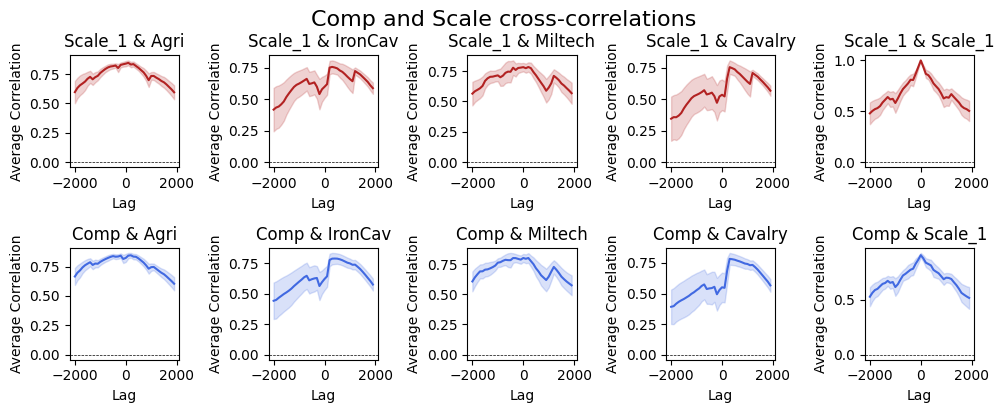

In [ ]:
ref_cols = ["Scale_1","Comp"]
pred_cols = ["Agri", "IronCav", "Miltech", "Cavalry","Scale_1"]
colors = ["firebrick", "royalblue"]
fig, ax = plt.subplots(len(ref_cols), len(pred_cols), figsize=(10, 4))

for i, col1 in enumerate(ref_cols):
    for j, col2 in enumerate(pred_cols):
        lags = np.arange(-20, 20)
        all_correlations = []
        for n,nga in enumerate(dataset.scv_imputed.NGA.unique()):
            df_nga = dataset.scv_imputed.loc[dataset.scv_imputed.NGA == nga]
            try:
                all_imputed_c1, all_imputed_c2 = impute_missing_values(df_nga, col1, col2)
            except ValueError:
                print(f"ValueError for {nga} - skipping")
                continue
            all_correlations.append(get_correlations(all_imputed_c2, all_imputed_c1))

        av_corr, av_se = get_av_correlation(lags, all_correlations)
        # plot
        ax[i,j].plot(lags*100, av_corr, label='Average Correlation', color=colors[i])
        ax[i,j].fill_between(lags*100, av_corr - av_se, av_corr + av_se, color= colors[i], alpha=0.2, label='Standard Error')
        ax[i,j].axhline(0, color='black', linestyle='--', linewidth=0.5)
        ax[i,j].set_xlabel('Lag')
        ax[i,j].set_ylabel('Average Correlation')
        ax[i,j].set_title(f'{col1} & {col2}')
plt.tight_layout()
plt.suptitle("Comp and Scale cross-correlations", fontsize=16, y=1.02)

Extract next Scale and Comp values

In [99]:
dr = dataset.scv_imputed.copy()
# remove rows without NGA value
dr = dr.dropna(subset=['NGA'])
dr['Scale_t'] = np.nan
dr['d_Scale'] = np.nan
dr['Comp_t'] = np.nan
dr['d_Comp'] = np.nan


dr_nga = dr.groupby('NGA')
for nga, group in dr_nga:
    group = group.sort_values(['Year', 'PolityID'])
    group.drop_duplicates(subset = ['Year'], keep = 'first', inplace = True)

    # find values 100 years later
    dr.loc[group.index, 'Scale_t'] = group['Scale_1'].shift(-1).values
    dr.loc[group.index, 'Comp_t'] = group['Comp'].shift(-1).values
    dr.loc[group.index, 'd_Scale'] = dr.loc[group.index, 'Scale_t'] - group['Scale_1']
    dr.loc[group.index, 'd_Comp'] = dr.loc[group.index, 'Comp_t'] - group['Comp']
    
    # remove rows without a value 100 yrs later
    mask = (group['Year'].shift(-1) - group['Year'] != 100)
    indices = group.index.intersection(mask[mask].index)
    if len(indices) > 2:
        print(len(indices)-1)

    dr.loc[indices,'Scale_t'] = np.nan
    dr.loc[indices,'Comp_t'] = np.nan
    dr.loc[indices,'d_Scale'] = np.nan
    dr.loc[indices,'d_Comp'] = np.nan



2
2
2
3
6
3
2
3


Fit Scale

In [108]:
dr = dataset.scv_imputed.copy()
# remove rows without NGA value
dr = dr.dropna(subset=['NGA'])
dr['Scale_t'] = np.nan
dr['d_Scale'] = np.nan
dr['Comp_t'] = np.nan
dr['d_Comp'] = np.nan


dr_nga = dr.groupby('NGA')
for nga, group in dr_nga:
    group = group.sort_values(['Year', 'PolityID'])
    group.drop_duplicates(subset = ['Year'], keep = 'first', inplace = True)

    # find values 100 years later
    dr.loc[group.index, 'Scale_t'] = group['Scale_1'].shift(-1).values
    dr.loc[group.index, 'Comp_t'] = group['Comp'].shift(-1).values
    dr.loc[group.index, 'd_Scale'] = dr.loc[group.index, 'Scale_t'] - group['Scale_1']
    dr.loc[group.index, 'd_Comp'] = dr.loc[group.index, 'Comp_t'] - group['Comp']
    
    # remove rows without a value 100 yrs later
    mask = (group['Year'].shift(-1) - group['Year'] != 100)
    indices = group.index.intersection(mask[mask].index)
    if len(indices) > 2:
        print(len(indices)-1)

    dr.loc[indices,'Scale_t'] = np.nan
    dr.loc[indices,'Comp_t'] = np.nan
    dr.loc[indices,'d_Scale'] = np.nan
    dr.loc[indices,'d_Comp'] = np.nan



2
2
2
3
6
3
2
3


In [98]:
x_cols = ['Scale_1','Agri', 'AgriLag', "Scale_sq", 'Comp', 'IronCav']
y_col = ['Scale_t']
Xy = dr
Xy['Scale_sq'] = Xy['Scale_1']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
X.drop(columns=['Comp'], inplace=True)
y = Xy[y_col]

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Scale_t   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     3102.
Date:                Mon, 16 Jun 2025   Prob (F-statistic):               0.00
Time:                        11:33:17   Log-Likelihood:                -482.72
No. Observations:                1033   AIC:                             977.4
Df Residuals:                    1027   BIC:                             1007.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        1.0595      0.056     18.818      0.0

C:\Users\matil\AppData\Local\Temp\ipykernel_16964\1930141167.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['Comp'], inplace=True)


In [ ]:
def analyze_residuals(values, residuals, bins):
    """
    Analyze residuals by binning comp values and calculating statistics
    
    Args:
        comp_values (array-like): Competitiveness values
        residuals (array-like): Model residuals
        bin_size (float): Size of bins (default 0.1)
    
    Returns:
        pandas.DataFrame with columns: Value, mean, SE, n, lower, upper
    """
    import pandas as pd
    import numpy as np

    bin_size = bins[1] - bins[0]
    # Initialize results
    results = []
    
    # Calculate stats for each bin
    for bin_center in bins[:-1]:
        mask = ((values >= bin_center - bin_size) & 
                (values < bin_center + bin_size))
        bin_residuals = residuals[mask]
        
        if len(bin_residuals) > 0:
            mean = np.mean(bin_residuals)
            se = np.std(bin_residuals)/np.sqrt(len(bin_residuals))
            results.append({
                'Value': bin_center + bin_size/2,
                'mean': mean,
                'SE': se,
                'n': len(bin_residuals),
                'lower': mean - se,
                'upper': mean + se
            })
    
    # Convert to dataframe
    df = pd.DataFrame(results)
    return df

Text(0, 0.5, 'Scale')

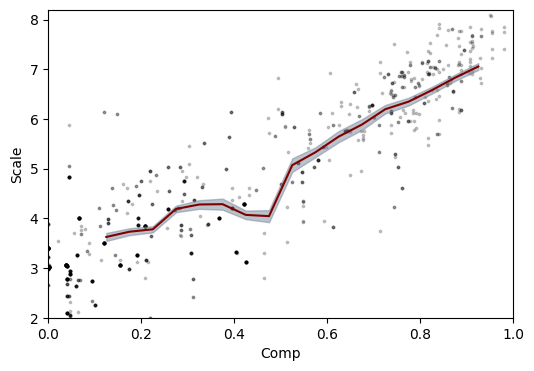

In [14]:
bins = np.arange(0.1, 1, 0.05)
results = analyze_residuals(Xy['Comp'].values, Xy['Scale_t'].values, bins)

plt.figure(figsize=(6, 4))
plt.scatter(Xy['Comp'].values, Xy['Scale_1'].values, color='k', alpha=0.2, label='Predictions', s=3)

plt.plot(results['Value'], results['mean'], color='maroon')
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightslategray', alpha=0.5)

plt.xlim(.0, 1)
plt.ylim(2,8.2)
plt.xlabel("Comp")
plt.ylabel("Scale")

(0.0, 0.95)

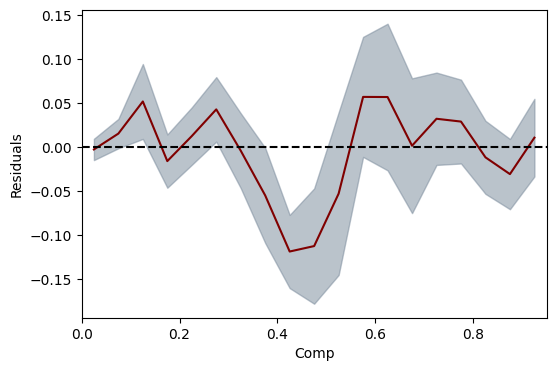

In [15]:
residuals = y['Scale_t'] - predictions.values
comp_values = Xy['Comp'].values
bins = np.arange(0., 1, 0.05)
results = analyze_residuals(comp_values, residuals, bins)
results_before = results.copy() 
residuals_before = residuals.copy()

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results['Value'], results['mean'], color='maroon')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightslategray', alpha=0.5)
# plot zero line
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comp')
plt.ylabel('Residuals')
x = np.linspace (-2,12,100)
# plt.scatter(Xy['Comp'], residuals, color='k', alpha=0.2, label='Predictions', s=3)

plt.xlim(0.0, 0.95)

In [16]:
thresh_start = np.arange(0.1, 0.9 , 0.01)
thresh_end = np.arange(0.2, 0.9, 0.01)
# x_cols = ['Scale_1','Scale_sq','Agri','AgriLag','Miltech','IronCav','Comp']
y_col = ['Scale_t']
Xy = dr
Xy['Scale_sq'] = Xy['Scale_1']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]

results = pd.DataFrame(columns=['thresh_start', 'thresh_end', 'n', 'R2', 'R2_adj', 'AIC', 'p', 'log-likelyhood','minres',"comp_pval"])

for thresh_s in thresh_start:
    for thresh_e in thresh_end:
        mask = (Xy.Comp >= thresh_s)&(Xy.Comp <= thresh_e)
        X['Comp'] = 0
        X.loc[mask, 'Comp'] = 1

        model = sm.OLS(y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        results = pd.concat([results, pd.DataFrame([{
            'thresh_start': thresh_s,
            'thresh_end': thresh_e,
            'n': len(y),
            'R2': model.rsquared,
            'R2_adj': model.rsquared_adj,
            'AIC': model.aic,
            'p': model.f_pvalue,
            'log-likelyhood': model.llf,
            'minres': np.mean(np.abs(y['Scale_t'].values - predictions)),
            'comp_pval': model.pvalues['Comp']
        }])], ignore_index=True)



C:\Users\matil\AppData\Local\Temp\ipykernel_26032\3551886444.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Comp'] = 0
C:\Users\matil\AppData\Local\Temp\ipykernel_26032\3551886444.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Comp'] = 0
C:\Users\matil\AppData\Local\Temp\ipykernel_26032\3551886444.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [17]:
results.sort_values('AIC', ascending=True).head(10)

thresh_start  thresh_end     n        R2    R2_adj         AIC    p  \
1711          0.34        0.51  1040  0.937719  0.937357  985.213032  0.0   
1921          0.37        0.51  1040  0.937613  0.937251  986.984840  0.0   
1991          0.38        0.51  1040  0.937613  0.937251  986.984840  0.0   
1712          0.34        0.52  1040  0.937603  0.937240  987.151854  0.0   
1781          0.35        0.51  1040  0.937598  0.937235  987.235171  0.0   
1851          0.36        0.51  1040  0.937598  0.937235  987.235171  0.0   
1641          0.33        0.51  1040  0.937582  0.937220  987.498140  0.0   
1713          0.34        0.53  1040  0.937556  0.937193  987.930107  0.0   
1710          0.34        0.50  1040  0.937553  0.937190  987.987318  0.0   
1571          0.32        0.51  1040  0.937540  0.937177  988.195463  0.0   

      log-likelyhood    minres  comp_pval  
1711     -485.606516  0.198436   0.000096  
1921     -486.492420  0.196777   0.000244  
1991     -486.492420  0.196777   0.000244  
1712     -486.575927  0.198291   0.000266  
1781     -486.617585  0.197526   0.000278  
1851     -486.617585  0.197526   0.000278  
1641     -486.749070  0.197419   0.000320  
1713     -486.965053  0.197971   0.000402  
1710     -486.993659  0.197049   0.000415  
1571     -487.097731  0.197411   0.000463

In [18]:
thresh_min = results.sort_values('AIC', ascending=True)[['thresh_start','thresh_end']].iloc[0].values
thresh_min =[0.34, 0.51]
mask = (Xy.Comp >= thresh_min[0])&(Xy.Comp <= thresh_min[1])
X['Comp'] = 0
X.loc[mask, 'Comp'] = 1

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Scale_t   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     2592.
Date:                Tue, 20 May 2025   Prob (F-statistic):               0.00
Time:                        14:17:04   Log-Likelihood:                -485.61
No. Observations:                1040   AIC:                             985.2
Df Residuals:                    1033   BIC:                             1020.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        1.1226      0.058     19.522      0.0

C:\Users\matil\AppData\Local\Temp\ipykernel_26032\2857829491.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Comp'] = 0


Text(0.5, 1.0, 'Residuals with and without thresholds model')

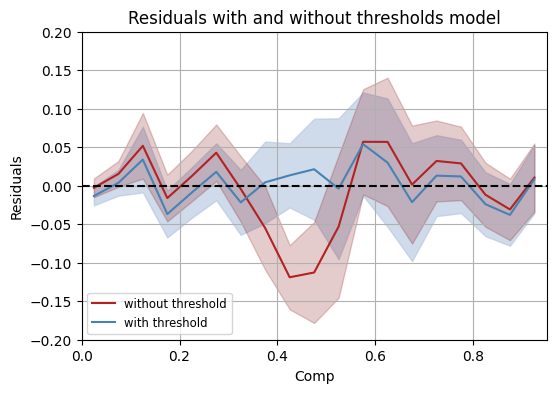

In [19]:
residuals = y['Scale_t'].values - predictions
comp_values = Xy['Comp'].values
bins = np.arange(0., 1, 0.05)
results = analyze_residuals(comp_values, residuals, bins)

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results_before['Value'], results_before['mean'], color='firebrick', label = 'without threshold')
plt.plot(results['Value'], results['mean'], color='steelblue', label = 'with threshold')
# plt.plot(results_before['Value'], results_before['mean'], color='blue')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightsteelblue', alpha=0.6)
plt.fill_between(results_before['Value'], results_before['lower'], results_before['upper'], color='maroon', alpha=0.2)

plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comp')
plt.ylabel('Residuals')
plt.legend(loc = 'lower left', fontsize = 'small')
plt.xlim(0.0, 0.95)
plt.ylim(-0.2, 0.2)
#  add grid
plt.grid(True)
plt.title('Residuals with and without thresholds model')

In [244]:
x_cols = ['Comp','Agri','Miltech','Comp_sq','Scale_1']
y_col = ['Comp_t']
Xy = dr
Xy['Comp_sq'] = Xy['Comp']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
X.drop(columns=['Scale_1'], inplace=True)
y = Xy[y_col]

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Comp_t   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     4989.
Date:                Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:29:16   Log-Likelihood:                 1327.7
No. Observations:                1071   AIC:                            -2645.
Df Residuals:                    1066   BIC:                            -2621.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Comp           1.0203      0.028     36.815      0.0

C:\Users\matil\AppData\Local\Temp\ipykernel_16408\1677285777.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['Scale_1'], inplace=True)


(2.0, 8.5)

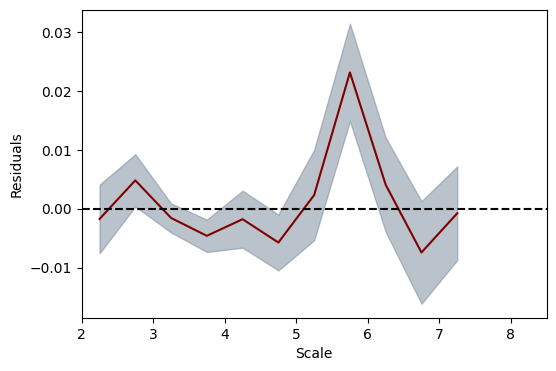

In [245]:
residuals = (y['Comp_t'].values - predictions)
scale_values = Xy['Scale_1'].values
bins = np.arange(2, 8, 0.5)

results = analyze_residuals(scale_values, residuals, bins)
results_before = results.copy()

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results['Value'], results['mean'], color='maroon')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightslategray', alpha=0.5)
# plot zero line
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Scale')
plt.ylabel('Residuals')
plt.xlim(2, 8.5)

In [254]:
thresh_start = np.arange(2, 8 , 0.1)
thresh_end = np.arange(6, 10, 0.1)
x_cols = ['Scale_1','Comp_sq','Agri','AgriLag','IronCav','Comp']
y_col = ['Comp_t']
Xy = dr
Xy['Comp_sq'] = Xy['Comp']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]

results = pd.DataFrame(columns=['thresh_start', 'thresh_end', 'n', 'R2', 'R2_adj', 'AIC', 'p','log-likelyhood','minres'])

for thresh_s in thresh_start:
    for thresh_e in thresh_end:
        mask = (Xy.Scale_1 >= thresh_s) & (Xy.Scale_1 < thresh_e)
        X['Scale_1'] = np.zeros(len(X))
        X.loc[mask, 'Scale_1'] = 1

        model = sm.OLS(y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        # save results
        results = pd.concat([results, pd.DataFrame([{
            'thresh_start': thresh_s,
            'thresh_end': thresh_e,
            'n': len(y),
            'R2': model.rsquared,
            'R2_adj': model.rsquared_adj,
            'AIC': model.aic,
            'p': model.f_pvalue,
            'log-likelyhood': model.llf,
            'minres': np.mean(np.abs(y['Comp_t'].values - predictions)),
            'scale_pval': model.pvalues['Scale_1']
        }])], ignore_index=True)


C:\Users\matil\AppData\Local\Temp\ipykernel_16408\3158661385.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Scale_1'] = np.zeros(len(X))
C:\Users\matil\AppData\Local\Temp\ipykernel_16408\3158661385.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{
C:\Users\matil\AppData\Local\Temp\ipykernel_16408\3158661385.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [255]:
results.loc[results.scale_pval.notna()].sort_values('AIC', ascending=True).head(10)


thresh_start  thresh_end     n        R2    R2_adj          AIC    p  \
1321           5.3         6.1  1040  0.952885  0.952612 -2633.115700  0.0   
1361           5.4         6.1  1040  0.952884  0.952611 -2633.096013  0.0   
1281           5.2         6.1  1040  0.952823  0.952549 -2631.735640  0.0   
1724           6.3         6.4  1040  0.952734  0.952460 -2629.781686  0.0   
1320           5.3         6.0  1040  0.952717  0.952442 -2629.398512  0.0   
1360           5.4         6.0  1040  0.952716  0.952442 -2629.393571  0.0   
1280           5.2         6.0  1040  0.952657  0.952382 -2628.087948  0.0   
1241           5.1         6.1  1040  0.952653  0.952378 -2627.998780  0.0   
1201           5.0         6.1  1040  0.952614  0.952339 -2627.140360  0.0   
1240           5.1         6.0  1040  0.952500  0.952224 -2624.641649  0.0   

      log-likelyhood    minres  scale_pval  
1321     1323.557850  0.032283    0.000001  
1361     1323.548007  0.032268    0.000001  
1281     1322.867820  0.032474    0.000003  
1724     1321.890843  0.032142    0.000008  
1320     1321.699256  0.032255    0.000009  
1360     1321.696786  0.032244    0.000009  
1280     1321.043974  0.032437    0.000019  
1241     1320.999390  0.032433    0.000020  
1201     1320.570180  0.032518    0.000031  
1240     1319.320824  0.032387    0.000113

In [256]:
# thresh_min = results.sort_values('minres', ascending=True)[['thresh_start','thresh_end']].iloc[1].values
thresh_min =[5.4, 6.]

mask = (Xy.Scale_1 >= thresh_min[0]) & (Xy.Scale_1 < thresh_min[1])
X['Scale_1'] = 0
X.loc[mask, 'Scale_1'] = 1

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Comp_t   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     3469.
Date:                Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:34:28   Log-Likelihood:                 1321.7
No. Observations:                1040   AIC:                            -2629.
Df Residuals:                    1033   BIC:                            -2595.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        0.0399      0.009      4.451      0.0

C:\Users\matil\AppData\Local\Temp\ipykernel_16408\1010782566.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Scale_1'] = 0


Text(0.5, 1.0, 'Residuals with and without thresholds model')

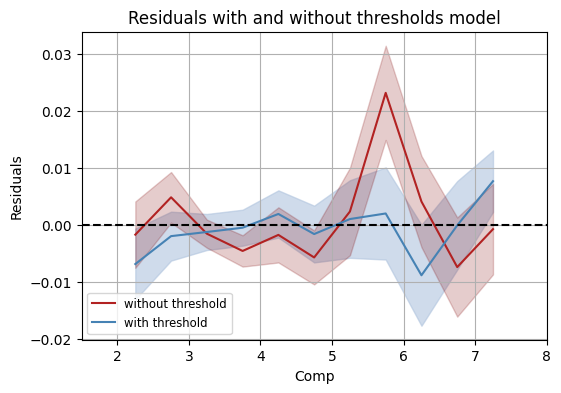

In [257]:
residuals = (y['Comp_t'].values - predictions)
scale_values = Xy['Scale_1'].values
bins = np.arange(2, 8, 0.5)
results = analyze_residuals(scale_values, residuals, bins)

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results_before['Value'], results_before['mean'], color='firebrick', label = 'without threshold')
plt.plot(results['Value'], results['mean'], color='steelblue', label = 'with threshold')
# plt.plot(results_before['Value'], results_before['mean'], color='blue')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightsteelblue', alpha=0.6)
plt.fill_between(results_before['Value'], results_before['lower'], results_before['upper'], color='maroon', alpha=0.2)

plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comp')
plt.ylabel('Residuals')
plt.legend(loc = 'lower left', fontsize = 'small')
plt.xlim(1.5, 8)
#  add grid
plt.grid(True)
plt.title('Residuals with and without thresholds model')

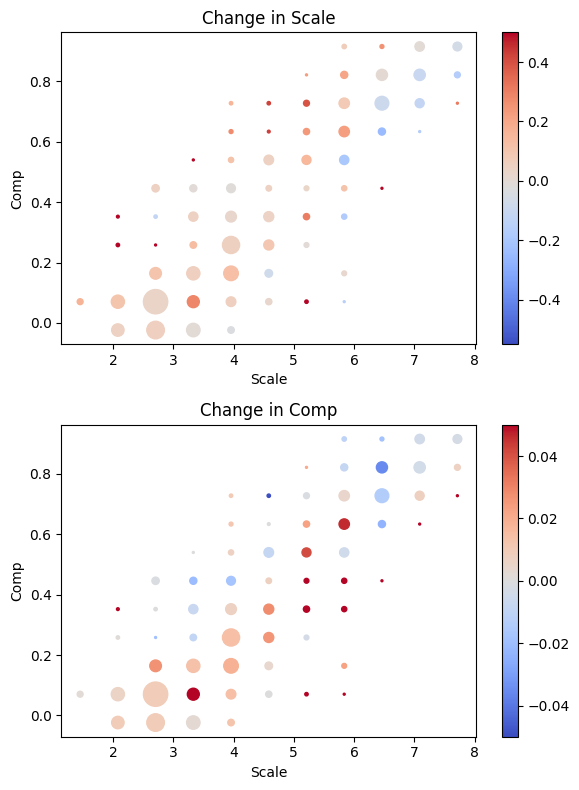

In [250]:
fig, ax = plt.subplots(2,1,figsize=(6, 8))

x_cols = ['Scale_1','Comp']
y_col = ['d_Scale','d_Comp']
Xy = dr[y_col+x_cols].dropna()

x = Xy["Scale_1"].values
y = Xy["Comp"].values
z1 = Xy["d_Scale"].values
z2 = Xy["d_Comp"].values

grid_size = 11

df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

# Define the grid
x_bins = np.linspace(min(x), max(x), grid_size + 1)
y_bins = np.linspace(min(y), max(y), grid_size + 1)

# Bin the data
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

# remove entries in grid that are not statistically significant
# grid_1[grid_1_std/2 > np.abs(grid_1)] = np.nan
# grid_2[grid_2_std/2 > np.abs(grid_2)] = np.nan

# -------------------------------- AXIS 1 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[0].scatter(x.flatten(), y.flatten(), c=grid_1.values.flatten(), cmap='coolwarm', s=counts_1.values.flatten()*2, vmax = -0.5, vmin = 0.5)
cbar = plt.colorbar(ax[0].collections[0], ax=ax[0])
ax[0].set_title('Change in Scale')
ax[0].set_ylabel('Comp')
ax[0].set_xlabel('Scale')

# -------------------------------- AXIS 2 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[1].scatter(x.flatten(), y.flatten(), c=grid_2.values.flatten(), cmap='coolwarm', s=counts_2.values.flatten()*2, vmax = 0.05, vmin = -0.05)
cbar = plt.colorbar(ax[1].collections[0], ax=ax[1])
ax[1].set_title('Change in Comp')
ax[1].set_ylabel('Comp')
ax[1].set_xlabel('Scale')

plt.tight_layout()
plt.show()

C:\Users\matil\AppData\Local\Temp\ipykernel_16408\1731759286.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  pink_r = plt.cm.get_cmap('pink_r')
C:\Users\matil\AppData\Local\Temp\ipykernel_16408\1731759286.py:14: RuntimeWarning: divide by zero encountered in divide
  std_2 = grid_2_std.values/grid_2.values
C:\Users\matil\AppData\Local\Temp\ipykernel_16408\1731759286.py:14: RuntimeWarning: invalid value encountered in divide
  std_2 = grid_2_std.values/grid_2.values


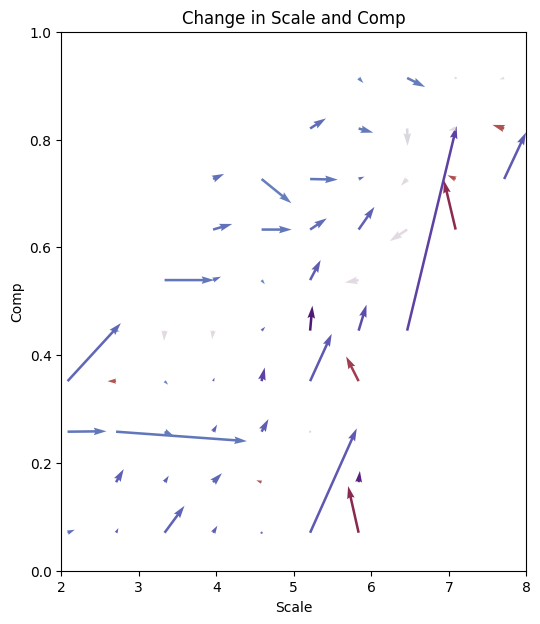

In [251]:
import seaborn as sns


# create vector plot
fig, ax = plt.subplots(figsize=(6, 7))
pink_r = plt.cm.get_cmap('pink_r')
# sns.histplot(x = dr.Scale_1, y = dr.Comp, bins=15, cmap = pink_r, alpha = 0.5, cbar = True, ax = ax)
u = np.clip(grid_1.values, -1, 1)
v = np.clip(grid_2.values, -0.1, 0.1)
u = grid_1.values
v = grid_2.values

std_1 = grid_1_std.values/grid_1.values
std_2 = grid_2_std.values/grid_2.values

std = np.sqrt(std_1**2 + std_2**2)
std = np.clip(std, 0, 20)
t_norm = np.reshape(std, -1)
t_scaled = (t_norm - t_norm[~np.isnan(t_norm)].min())/(t_norm[~np.isnan(t_norm)].max() - t_norm[~np.isnan(t_norm)].min())  # Normalize to 0-1

x, y = np.meshgrid(x_bins, y_bins)
# color arrows according to angle
color = np.arctan2(v, u)
color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA

ax.quiver(x, y, u, v, scale_units='xy', angles='xy',
           color=color.reshape(-1, 4),
           alpha=1,  scale=1.1)
ax.set_xlim(2, 8)
ax.set_ylim(0,1.)
ax.set_ylabel('Comp')
ax.set_xlabel('Scale')
plt.title('Change in Scale and Comp')
plt.show()

C:\Users\matil\AppData\Local\Temp\ipykernel_16408\1355743016.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  pink_r = plt.cm.get_cmap('pink_r')
C:\Users\matil\AppData\Local\Temp\ipykernel_16408\1355743016.py:50: RuntimeWarning: invalid value encountered in divide
  std_1 = grid_1_std.values/grid_1.values
C:\Users\matil\AppData\Local\Temp\ipykernel_16408\1355743016.py:51: RuntimeWarning: invalid value encountered in divide
  std_2 = grid_2_std.values/grid_2.values
C:\Users\matil\AppData\Local\Temp\ipykernel_16408\1355743016.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  pink_r = plt.cm.get_cmap('pink_r')
C:\Users\matil\AppData

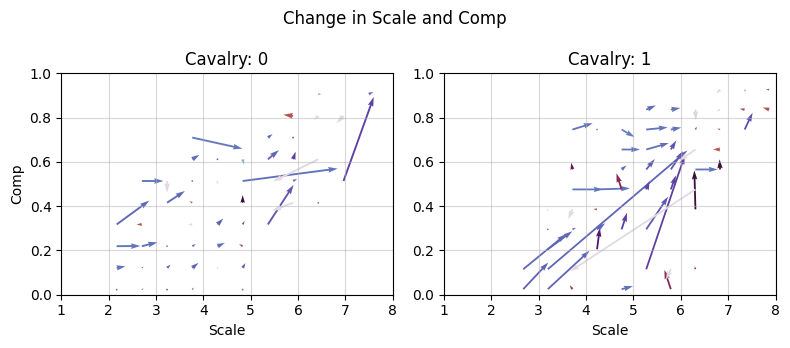

In [252]:
import seaborn as sns

cav = [0, 1, 2]

colors = ['firebrick', 'steelblue', 'darkorange']

fig, ax = plt.subplots(1,2,figsize=(8, 3.5))
cav = [0,1]
# plt.minorticks_on()
for n,c in enumerate(cav):
    Xy = dr.loc[(dr.Cavalry == c)]
    x = Xy["Scale_1"].values
    y = Xy["Comp"].values
    z1 = Xy["d_Scale"].values
    z2 = Xy["d_Comp"].values

    grid_size = 11

    df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

    # Define the grid
    x_bins = np.linspace(min(x), max(x), grid_size + 1)
    y_bins = np.linspace(min(y), max(y), grid_size + 1)

    # Bin the data
    df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
    df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


    x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
    y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

    # Group by the bins and calculate the mean of z
    grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
    grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
    counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

    grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
    grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
    counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

    # create vector plot
    pink_r = plt.cm.get_cmap('pink_r')
    # sns.histplot(x = dr.Scale_1, y = dr.Comp, bins=15, cmap = pink_r, alpha = 0.5, cbar = True, ax = ax)
    u = np.clip(grid_1.values, -1, 1)
    v = np.clip(grid_2.values, -0.1, 0.1)
    u = grid_1.values
    v = grid_2.values

    std_1 = grid_1_std.values/grid_1.values
    std_2 = grid_2_std.values/grid_2.values

    std = np.sqrt(std_1**2 + std_2**2)
    std = np.clip(std, 0, 20)
    t_norm = np.reshape(std, -1)
    t_scaled = (t_norm - t_norm[~np.isnan(t_norm)].min())/(t_norm[~np.isnan(t_norm)].max() - t_norm[~np.isnan(t_norm)].min())  # Normalize to 0-1

    x, y = np.meshgrid(x_bins, y_bins)
    # color arrows according to angle
    color = np.arctan2(v, u)
    color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA

    ax[n].quiver(x, y, u, v, scale_units='xy', angles='xy',
            color=color.reshape(-1, 4),
            alpha=1.,  scale=1.1)
    ax[n].set_xlim(1, 8)
    ax[n].set_ylim(0, 1.)
    ax[0].set_ylabel('Comp')
    ax[n].set_title(f'Cavalry: {c}')
    ax[n].grid(True,  alpha=0.5)
    
    ax[n].set_xlabel('Scale')
plt.suptitle('Change in Scale and Comp')
plt.tight_layout()
plt.show()

In [253]:
changes = pd.DataFrame(columns = ['NGA', 'PolityName', 'Scale', 'Comp', 'd_Scale', 'd_Comp'])

scv_imp_nga = dataset.scv_imputed.groupby('NGA')
for nga, group in scv_imp_nga:
    group = group.sort_values(['Year', 'PolityID'])

    pol_nga = group.groupby('PolityID')
    polities = pol_nga['PolityName'].first()
    scales = pol_nga['Scale_1'].apply(np.mean)
    comps = pol_nga['Comp'].apply(np.mean)
    years = pol_nga['Year'].apply(np.mean)

    d_year = (years.shift(-1)-years)/100
    d_scales = (scales.shift(-1)-scales)/d_year
    d_comps = (comps.shift(-1) - comps)/d_year

    df_temp = pd.DataFrame({'NGA': nga, 'PolityName':polities, 'Scale': scales, 'Comp': comps, 'd_Scale': d_scales, 'd_Comp': d_comps})
    changes = changes.append(df_temp)
changes.dropna(subset = ['d_Scale', 'd_Comp'], inplace = True)

AttributeError: 'DataFrame' object has no attribute 'append'

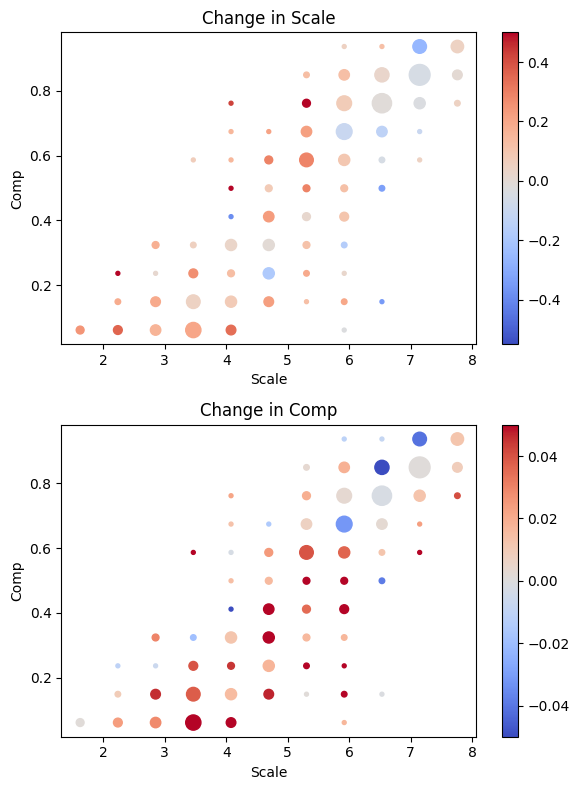

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(6, 8))

Xy = changes

x = Xy["Scale"].values
y = Xy["Comp"].values
z1 = Xy["d_Scale"].values
z2 = Xy["d_Comp"].values

grid_size = 11

df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

# Define the grid
x_bins = np.linspace(min(x), max(x), grid_size + 1)
y_bins = np.linspace(min(y), max(y), grid_size + 1)

# Bin the data
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

# remove entries in grid that are not statistically significant
# grid_1[grid_1_std > np.abs(grid_1)] = np.nan
# grid_2[grid_2_std > np.abs(grid_2)] = np.nan

# -------------------------------- AXIS 1 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[0].scatter(x.flatten(), y.flatten(), c=grid_1.values.flatten(), cmap='coolwarm', s=counts_1.values.flatten()*8, vmax = -0.5, vmin = 0.5)
cbar = plt.colorbar(ax[0].collections[0], ax=ax[0])
ax[0].set_title('Change in Scale')
ax[0].set_ylabel('Comp')
ax[0].set_xlabel('Scale')

# -------------------------------- AXIS 2 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[1].scatter(x.flatten(), y.flatten(), c=grid_2.values.flatten(), cmap='coolwarm', s=counts_2.values.flatten()*8, vmax = 0.05, vmin = -0.05)
cbar = plt.colorbar(ax[1].collections[0], ax=ax[1])
ax[1].set_title('Change in Comp')
ax[1].set_ylabel('Comp')
ax[1].set_xlabel('Scale')

plt.tight_layout()
plt.show()

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_52001/1507440410.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r = plt.cm.get_cmap('pink_r')


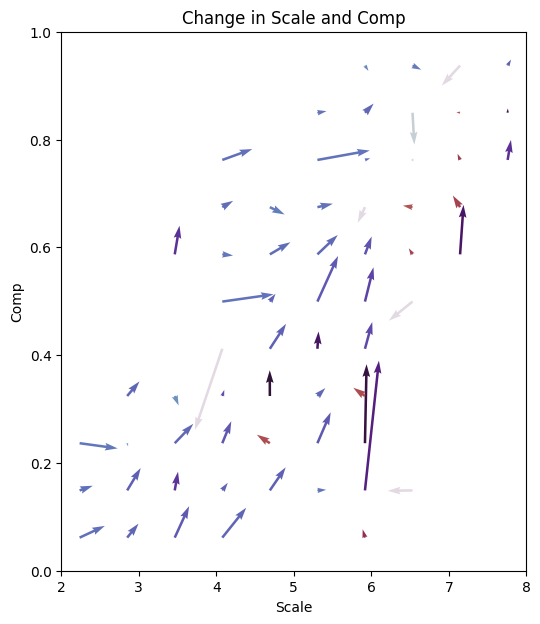

In [ ]:
import seaborn as sns
# create vector plot
fig, ax = plt.subplots(figsize=(6, 7))
pink_r = plt.cm.get_cmap('pink_r')
# sns.histplot(x = dr.Scale_1, y = dr.Comp, bins=15, cmap = pink_r, alpha = 0.5, cbar = True, ax = ax)
u = np.clip(grid_1.values, -1, 2)
v = np.clip(grid_2.values, -0.1, 0.2)
u = grid_1.values
v = grid_2.values

std_1 = grid_1_std.values/grid_1.values
std_2 = grid_2_std.values/grid_2.values

std = np.sqrt(std_1**2 + std_2**2)
std = np.clip(std, 0, 20)
t_norm = np.reshape(std, -1)
t_scaled = (t_norm - t_norm[~np.isnan(t_norm)].min())/(t_norm[~np.isnan(t_norm)].max() - t_norm[~np.isnan(t_norm)].min())  # Normalize to 0-1

x, y = np.meshgrid(x_bins, y_bins)
# color arrows according to angle
color = np.arctan2(v, u)
color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA

ax.quiver(x, y, u, v, scale_units='xy', angles='xy',
           color=color.reshape(-1, 4),
           alpha=1,  scale=1.1)
ax.set_xlim(2, 8)
ax.set_ylim(0,1.)
ax.set_ylabel('Comp')
ax.set_xlabel('Scale')
plt.title('Change in Scale and Comp')
plt.show()